In [1]:
%matplotlib inline
# python libraties
import os, cv2,itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
from PIL import Image

# pytorch libraries
import torch
from torch import optim,nn
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
from torchvision import models,transforms

# sklearn libraries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# to make the results are reproducible
np.random.seed(10)
torch.manual_seed(10)
torch.cuda.manual_seed(10)

print(os.listdir("dataset"))

['HAM10000_metadata.csv', 'HAM10000_images_part_1', 'hmnist_8_8_L.csv', 'hmnist_28_28_RGB.csv', 'HAM10000_images_part_2', 'hmnist_8_8_RGB.csv', 'hmnist_28_28_L.csv']


In [2]:
data_dir = 'dataset'
all_image_path = glob(os.path.join(data_dir, '*', '*.jpg'))
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in all_image_path}
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'dermatofibroma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [3]:
def compute_img_mean_std(image_paths):
    """
        computing the mean and std of three channel on the whole dataset,
        first we should normalize the image from 0-255 to 0-1
    """

    img_h, img_w = 224, 224
    imgs = []
    means, stdevs = [], []

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        imgs.append(img)

    imgs = np.stack(imgs, axis=3)
    print(imgs.shape)

    imgs = imgs.astype(np.float32) / 255.

    for i in range(3):
        pixels = imgs[:, :, i, :].ravel()  # resize to one row
        means.append(np.mean(pixels))
        stdevs.append(np.std(pixels))

    means.reverse()  # BGR --> RGB
    stdevs.reverse()

    print("normMean = {}".format(means))
    print("normStd = {}".format(stdevs))
    return means,stdevs

In [4]:
norm_mean, norm_std = compute_img_mean_std(all_image_path)

100%|█████████████████████████████████████████████████████████████████████████████| 10015/10015 [03:09<00:00, 52.91it/s]


(224, 224, 3, 10015)
normMean = [0.76303905, 0.54564434, 0.5700453]
normStd = [0.14092831, 0.15261248, 0.16997118]


In [5]:
df_original = pd.read_csv(os.path.join(data_dir, 'HAM10000_metadata.csv'))
df_original['path'] = df_original['image_id'].map(imageid_path_dict.get)
df_original['cell_type'] = df_original['dx'].map(lesion_type_dict.get)
df_original['cell_type_idx'] = pd.Categorical(df_original['cell_type']).codes
df_original.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,dataset/HAM10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,dataset/HAM10000_images_part_1/ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,dataset/HAM10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,dataset/HAM10000_images_part_1/ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,dataset/HAM10000_images_part_2/ISIC_0031633.jpg,Benign keratosis-like lesions,2


In [6]:
# Count the number of females and males in the dataset
gender_counts = df_original['sex'].value_counts()
print(gender_counts)


male       5406
female     4552
unknown      57
Name: sex, dtype: int64


In [7]:
# this will tell us how many images are associated with each lesion_id
df_undup = df_original.groupby('lesion_id').count()
# now we filter out lesion_id's that have only one image associated with it
df_undup = df_undup[df_undup['image_id'] == 1]
df_undup.reset_index(inplace=True)
df_undup.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000001,1,1,1,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1,1,1,1


In [8]:
# here we identify lesion_id's that have duplicate images and those that have only one image.
def get_duplicates(x):
    unique_list = list(df_undup['lesion_id'])
    if x in unique_list:
        return 'unduplicated'
    else:
        return 'duplicated'

# create a new colum that is a copy of the lesion_id column
df_original['duplicates'] = df_original['lesion_id']
# apply the function to this new column
df_original['duplicates'] = df_original['duplicates'].apply(get_duplicates)
df_original.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,dataset/HAM10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like lesions,2,duplicated
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,dataset/HAM10000_images_part_1/ISIC_0025030.jpg,Benign keratosis-like lesions,2,duplicated
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,dataset/HAM10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions,2,duplicated
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,dataset/HAM10000_images_part_1/ISIC_0025661.jpg,Benign keratosis-like lesions,2,duplicated
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,dataset/HAM10000_images_part_2/ISIC_0031633.jpg,Benign keratosis-like lesions,2,duplicated


In [9]:
df_original['duplicates'].value_counts()

unduplicated    5514
duplicated      4501
Name: duplicates, dtype: int64

In [10]:
# now we filter out images that don't have duplicates
df_undup = df_original[df_original['duplicates'] == 'unduplicated']
df_undup.shape

(5514, 11)

In [11]:
y = df_undup['cell_type_idx']
df_train, df_val = train_test_split(df_undup, test_size=0.5, random_state=101, stratify=y)
df_train.shape, df_val.shape

((2757, 11), (2757, 11))

In [12]:
# Calculate the number of males and females in the train dataset
train_male_count = len(df_train[df_train['sex'] == 'male'])
train_female_count = len(df_train[df_train['sex'] == 'female'])

# Calculate the number of males and females in the validation dataset
val_male_count = len(df_val[df_val['sex'] == 'male'])
val_female_count = len(df_val[df_val['sex'] == 'female'])

print("Training dataset:")
print(f"Males: {train_male_count}")
print(f"Females: {train_female_count}")

print("\nValidation dataset:")
print(f"Males: {val_male_count}")
print(f"Females: {val_female_count}")


Training dataset:
Males: 1435
Females: 1300

Validation dataset:
Males: 1472
Females: 1262


In [13]:
df_val['cell_type_idx'].value_counts()

4    2208
2     220
6     115
1      88
0      75
5      32
3      19
Name: cell_type_idx, dtype: int64

In [14]:
df_train['cell_type_idx'].value_counts()

4    2207
2     220
6     115
1      87
0      76
5      32
3      20
Name: cell_type_idx, dtype: int64

In [15]:
# This set will be df_original excluding all rows that are in the val set
# This function identifies if an image is part of the train or val set.
def get_val_rows(x):
    # create a list of all the lesion_id's in the val set
    val_list = list(df_val['image_id'])
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'

# identify train and val rows
# create a new colum that is a copy of the image_id column
df_original['train_or_val'] = df_original['image_id']
# apply the function to this new column
df_original['train_or_val'] = df_original['train_or_val'].apply(get_val_rows)
# filter out train rows
df_train = df_original[df_original['train_or_val'] == 'train']
print(f"Training dataset: {len(df_train)}")
print(f"Validation dataset: { len(df_val)}")

Training dataset: 7258
Validation dataset: 2757


In [16]:
# Calculate the number of males and females in the train dataset
train_male_count = len(df_train[df_train['sex'] == 'male'])
train_female_count = len(df_train[df_train['sex'] == 'female'])

# Calculate the number of males and females in the validation dataset
val_male_count = len(df_val[df_val['sex'] == 'male'])
val_female_count = len(df_val[df_val['sex'] == 'female'])

print("Training dataset:")
print(f"Males: {train_male_count}")
print(f"Females: {train_female_count}")

print("\nValidation dataset:")
print(f"Males: {val_male_count}")
print(f"Females: {val_female_count}")


Training dataset:
Males: 3934
Females: 3290

Validation dataset:
Males: 1472
Females: 1262


In [17]:
df_train['cell_type_idx'].value_counts()

4    4497
6     998
2     879
1     426
0     252
5     110
3      96
Name: cell_type_idx, dtype: int64

In [18]:
df_val['cell_type'].value_counts()

Melanocytic nevi                  2208
Benign keratosis-like lesions      220
dermatofibroma                     115
Basal cell carcinoma                88
Actinic keratoses                   75
Vascular lesions                    32
Dermatofibroma                      19
Name: cell_type, dtype: int64

In [19]:
df_train['sex'].value_counts()

male       3934
female     3290
unknown      34
Name: sex, dtype: int64

In [20]:
df_train['age'].value_counts()

45.0    835
50.0    786
55.0    686
40.0    666
70.0    605
60.0    572
65.0    567
35.0    539
75.0    477
30.0    363
80.0    312
85.0    254
25.0    194
20.0    146
15.0     74
5.0      74
0.0      38
10.0     37
Name: age, dtype: int64

In [21]:
df_train['localization'].value_counts()

back               1691
lower extremity    1461
upper extremity     879
trunk               803
abdomen             674
face                630
chest               350
foot                240
unknown             141
neck                132
scalp               109
hand                 66
ear                  48
genital              28
acral                 6
Name: localization, dtype: int64

## Bias Mitigation: Data Augmentation (Oversampling training data)

In [22]:
# # Copy fewer class to balance the number of 7 classes
data_aug_rate = [15,10,5,50,0,40,5]
for i in range(7):
    if data_aug_rate[i]:
        df_train=df_train.append([df_train.loc[df_train['cell_type_idx'] == i,:]]*(data_aug_rate[i]-1), ignore_index=True)
df_train['cell_type'].value_counts()

/tmp/ipykernel_4130930/2085359477.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_train=df_train.append([df_train.loc[df_train['cell_type_idx'] == i,:]]*(data_aug_rate[i]-1), ignore_index=True)


dermatofibroma                    4990
Dermatofibroma                    4800
Melanocytic nevi                  4497
Vascular lesions                  4400
Benign keratosis-like lesions     4395
Basal cell carcinoma              4260
Actinic keratoses                 3780
Name: cell_type, dtype: int64

In [23]:
# split validation into val and test
df_val, df_test = train_test_split(df_val, test_size=0.7)  
df_train = df_train.reset_index()
df_val = df_val.reset_index()
df_test = df_test.reset_index()


In [50]:
print(f" Training dataset size: {len(df_train)}")
print(f" Testing dataset size: {len(df_test)}")
print(f" Validation dataset size: {len(df_val)}")

 Training dataset size: 31122
 Testing dataset size: 1930
 Validation dataset size: 827


In [51]:
# feature_extract is a boolean that defines if we are finetuning or feature extracting. 
# If feature_extract = False, the model is finetuned and all model parameters are updated. 
# If feature_extract = True, only the last layer parameters are updated, the others remain fixed.
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [52]:


from torchvision.models import resnet18, vgg16, densenet121, inception_v3, resnet50, resnet101
from torchvision.models.densenet import DenseNet121_Weights

def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18, resnet34, resnet50, resnet101
        """
        model_ft = resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = vgg16_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "densenet":
        """ Densenet121
        """
        model_ft = densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1 if use_pretrained else None)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size


In [53]:
# resnet,vgg,densenet,inception
model_name = 'densenet'
num_classes = 7
feature_extract = False
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
# Define the device:
device = torch.device('cuda:2')
# Put the model on the device:
model = model_ft.to(device)


In [54]:
train_transform = transforms.Compose([transforms.Resize((224, 224)),transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),transforms.RandomRotation(20),
                                      transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
                                        transforms.ToTensor(), transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
# define the transformation of the val images.
val_transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(),
                                    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

# define the transformation of the val images.
test_transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(),
                                    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

In [55]:
class HAM10000(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # Load data and get label
        X = Image.open(self.df['path'][index])
        y = torch.tensor(int(self.df['cell_type_idx'][index]))

        if self.transform:
            X = self.transform(X)

        return X, y

In [56]:
# Define the training set using the table train_df and using our defined transitions (train_transform)
training_set = HAM10000(df_train, transform=train_transform)
train_loader = DataLoader(training_set, batch_size=32, shuffle=True, num_workers=4)


# transform for the validation set
validation_set = HAM10000(df_val, transform=val_transform)
val_loader = DataLoader(validation_set, batch_size=32, shuffle=False, num_workers=4)
# transform for the test  set (No jitter, rotations)
test_set = HAM10000(df_test, transform=test_transform)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=4)

## Bias Mitigation in classes :

### Multi-class Cross entropy loss

In [57]:
# # we use Adam optimizer, use cross entropy loss as our loss function
# optimizer = optim.Adam(model.parameters(), lr=1e-3)
# criterion = nn.CrossEntropyLoss().to(device)

### Weighted Multi-class Cross entropy loss

In [76]:
# from sklearn.utils.class_weight import compute_class_weight

# # Compute class weights for imbalanced dataset
# class_weights = compute_class_weight('balanced', classes=np.unique(df_train['cell_type_idx']), y=df_train['cell_type_idx'])
# class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)



# # we use Adam optimizer, use weighted-cross entropy loss as our loss function
# criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)

# optimizer = optim.Adam(model.parameters(), lr=1e-3)


### Class balance loss

In [58]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ClassBalancedCrossEntropyLoss(nn.Module):
    def __init__(self, num_samples, beta=0.9999):
        super(ClassBalancedCrossEntropyLoss, self).__init__()
        self.beta = beta
        self.num_samples = num_samples

        # Compute the effective number of samples
        self.effective_num_samples = (1 - self.beta ** self.num_samples) / (1 - self.beta)
        self.weights = (1 - self.beta) / self.effective_num_samples


    def forward(self, inputs, targets):
        log_probs = F.log_softmax(inputs, dim=1)
        targets_one_hot = F.one_hot(targets, num_classes=len(self.weights)).float()
        weighted_log_probs = targets_one_hot * self.weights.unsqueeze(0) * log_probs
        loss = -weighted_log_probs.sum() / inputs.size(0)
        return loss





In [59]:
num_samples = df_train['cell_type_idx'].value_counts().sort_index().values
num_samples = torch.tensor(num_samples, dtype=torch.float).to(device)

beta = 0.9999  # You can adjust this parameter based on your needs
criterion = ClassBalancedCrossEntropyLoss(num_samples, beta=beta).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [60]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [61]:
total_loss_train, total_acc_train = [],[]
def train(train_loader, model, criterion, optimizer, epoch):
    model.train()
    train_loss = AverageMeter()
    train_acc = AverageMeter()
    curr_iter = (epoch - 1) * len(train_loader)
    for i, data in enumerate(train_loader):
        images, labels = data
        N = images.size(0)
        # print('image shape:',images.size(0), 'label shape',labels.size(0))
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        prediction = outputs.max(1, keepdim=True)[1]
        train_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)
        train_loss.update(loss.item())
        curr_iter += 1
        if (i + 1) % 100 == 0:
            print('[epoch %d], [iter %d / %d], [train loss %.5f], [train acc %.5f]' % (
                epoch, i + 1, len(train_loader), train_loss.avg, train_acc.avg))
            total_loss_train.append(train_loss.avg)
            total_acc_train.append(train_acc.avg)
    return train_loss.avg, train_acc.avg

In [62]:
def validate(val_loader, model, criterion, optimizer, epoch):
    model.eval()
    val_loss = AverageMeter()
    val_acc = AverageMeter()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            images, labels = data
            N = images.size(0)
            images = Variable(images).to(device)
            labels = Variable(labels).to(device)

            outputs = model(images)
            prediction = outputs.max(1, keepdim=True)[1]

            val_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)

            val_loss.update(criterion(outputs, labels).item())

    print('------------------------------------------------------------')
    print('[epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, val_loss.avg, val_acc.avg))
    print('------------------------------------------------------------')
    return val_loss.avg, val_acc.avg

### Oversampling

In [50]:
epoch_num = 25
best_val_acc = 0
total_loss_val, total_acc_val = [],[]
for epoch in range(1, epoch_num+1):
    loss_train, acc_train = train(train_loader, model, criterion, optimizer, epoch)
    loss_val, acc_val = validate(val_loader, model, criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        torch.save(model.state_dict(), "densenet121_skin_lesion_class_bias_oversampling.pt")
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')

        

[epoch 1], [iter 100 / 973], [train loss 1.27444], [train acc 0.52156]
[epoch 1], [iter 200 / 973], [train loss 1.14463], [train acc 0.57141]
[epoch 1], [iter 300 / 973], [train loss 1.05542], [train acc 0.60396]
[epoch 1], [iter 400 / 973], [train loss 1.00065], [train acc 0.62438]
[epoch 1], [iter 500 / 973], [train loss 0.95442], [train acc 0.64163]
[epoch 1], [iter 600 / 973], [train loss 0.91879], [train acc 0.65385]
[epoch 1], [iter 700 / 973], [train loss 0.89889], [train acc 0.66031]
[epoch 1], [iter 800 / 973], [train loss 0.87162], [train acc 0.67172]
[epoch 1], [iter 900 / 973], [train loss 0.84772], [train acc 0.68045]
------------------------------------------------------------
[epoch 1], [val loss 0.46707], [val acc 0.83903]
------------------------------------------------------------
*****************************************************
best record: [epoch 1], [val loss 0.46707], [val acc 0.83903]
*****************************************************
[epoch 2], [iter 100

[epoch 10], [iter 200 / 973], [train loss 0.18965], [train acc 0.93047]
[epoch 10], [iter 300 / 973], [train loss 0.20088], [train acc 0.92604]
[epoch 10], [iter 400 / 973], [train loss 0.20438], [train acc 0.92453]
[epoch 10], [iter 500 / 973], [train loss 0.19904], [train acc 0.92669]
[epoch 10], [iter 600 / 973], [train loss 0.19931], [train acc 0.92625]
[epoch 10], [iter 700 / 973], [train loss 0.19754], [train acc 0.92616]
[epoch 10], [iter 800 / 973], [train loss 0.19416], [train acc 0.92754]
[epoch 10], [iter 900 / 973], [train loss 0.19230], [train acc 0.92802]
------------------------------------------------------------
[epoch 10], [val loss 0.33406], [val acc 0.89761]
------------------------------------------------------------
*****************************************************
best record: [epoch 10], [val loss 0.33406], [val acc 0.89761]
*****************************************************
[epoch 11], [iter 100 / 973], [train loss 0.18225], [train acc 0.92969]
[epoch 11

[epoch 19], [iter 700 / 973], [train loss 0.09678], [train acc 0.96415]
[epoch 19], [iter 800 / 973], [train loss 0.09631], [train acc 0.96422]
[epoch 19], [iter 900 / 973], [train loss 0.09526], [train acc 0.96500]
------------------------------------------------------------
[epoch 19], [val loss 0.39418], [val acc 0.91662]
------------------------------------------------------------
[epoch 20], [iter 100 / 973], [train loss 0.09246], [train acc 0.96656]
[epoch 20], [iter 200 / 973], [train loss 0.08441], [train acc 0.96969]
[epoch 20], [iter 300 / 973], [train loss 0.08795], [train acc 0.96854]
[epoch 20], [iter 400 / 973], [train loss 0.08660], [train acc 0.96883]
[epoch 20], [iter 500 / 973], [train loss 0.08632], [train acc 0.96862]
[epoch 20], [iter 600 / 973], [train loss 0.08669], [train acc 0.96833]
[epoch 20], [iter 700 / 973], [train loss 0.08818], [train acc 0.96790]
[epoch 20], [iter 800 / 973], [train loss 0.08773], [train acc 0.96777]
[epoch 20], [iter 900 / 973], [train

### Class balance loss

In [80]:
epoch_num = 25
best_val_acc = 0
total_loss_val, total_acc_val = [],[]
for epoch in range(1, epoch_num+1):
    loss_train, acc_train = train(train_loader, model, criterion, optimizer, epoch)
    loss_val, acc_val = validate(val_loader, model, criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        torch.save(model.state_dict(), "densenet121_skin_lesion_class_bias_class_balance_loss.pt")
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')

        

[epoch 1], [iter 100 / 227], [train loss 1.77847], [train acc 0.31719]
[epoch 1], [iter 200 / 227], [train loss 1.73138], [train acc 0.36469]
------------------------------------------------------------
[epoch 1], [val loss 4.61232], [val acc 0.30533]
------------------------------------------------------------
*****************************************************
best record: [epoch 1], [val loss 4.61232], [val acc 0.30533]
*****************************************************
[epoch 2], [iter 100 / 227], [train loss 1.64843], [train acc 0.40156]
[epoch 2], [iter 200 / 227], [train loss 1.57836], [train acc 0.43844]
------------------------------------------------------------
[epoch 2], [val loss 4.84062], [val acc 0.19146]
------------------------------------------------------------
[epoch 3], [iter 100 / 227], [train loss 1.57868], [train acc 0.40906]
[epoch 3], [iter 200 / 227], [train loss 1.51501], [train acc 0.44375]
------------------------------------------------------------
[

------------------------------------------------------------
[epoch 25], [val loss 0.81414], [val acc 0.81259]
------------------------------------------------------------


### Oversampling + Class balance loss

In [40]:
epoch_num = 25
best_val_acc = 0
total_loss_val, total_acc_val = [],[]
for epoch in range(1, epoch_num+1):
    loss_train, acc_train = train(train_loader, model, criterion, optimizer, epoch)
    loss_val, acc_val = validate(val_loader, model, criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        torch.save(model.state_dict(), "densenet121_skin_lesion_class_bias_oversampling_class_balance_loss.pt")
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')

        

[epoch 1], [iter 100 / 973], [train loss 1.31358], [train acc 0.50281]
[epoch 1], [iter 200 / 973], [train loss 1.18710], [train acc 0.55875]
[epoch 1], [iter 300 / 973], [train loss 1.10418], [train acc 0.58823]
[epoch 1], [iter 400 / 973], [train loss 1.04262], [train acc 0.60977]
[epoch 1], [iter 500 / 973], [train loss 0.98997], [train acc 0.62813]
[epoch 1], [iter 600 / 973], [train loss 0.95875], [train acc 0.64000]
[epoch 1], [iter 700 / 973], [train loss 0.92590], [train acc 0.65250]
[epoch 1], [iter 800 / 973], [train loss 0.89717], [train acc 0.66344]
[epoch 1], [iter 900 / 973], [train loss 0.87050], [train acc 0.67337]
------------------------------------------------------------
[epoch 1], [val loss 0.50158], [val acc 0.83204]
------------------------------------------------------------
*****************************************************
best record: [epoch 1], [val loss 0.50158], [val acc 0.83204]
*****************************************************
[epoch 2], [iter 100

[epoch 10], [iter 700 / 973], [train loss 0.18808], [train acc 0.92616]
[epoch 10], [iter 800 / 973], [train loss 0.18759], [train acc 0.92648]
[epoch 10], [iter 900 / 973], [train loss 0.18757], [train acc 0.92694]
------------------------------------------------------------
[epoch 10], [val loss 0.59026], [val acc 0.86133]
------------------------------------------------------------
[epoch 11], [iter 100 / 973], [train loss 0.17136], [train acc 0.93000]
[epoch 11], [iter 200 / 973], [train loss 0.17420], [train acc 0.93156]
[epoch 11], [iter 300 / 973], [train loss 0.17821], [train acc 0.93031]
[epoch 11], [iter 400 / 973], [train loss 0.17460], [train acc 0.93102]
[epoch 11], [iter 500 / 973], [train loss 0.16895], [train acc 0.93263]
[epoch 11], [iter 600 / 973], [train loss 0.17081], [train acc 0.93120]
[epoch 11], [iter 700 / 973], [train loss 0.17054], [train acc 0.93188]
[epoch 11], [iter 800 / 973], [train loss 0.17334], [train acc 0.93133]
[epoch 11], [iter 900 / 973], [train

[epoch 20], [iter 300 / 973], [train loss 0.09170], [train acc 0.96396]
[epoch 20], [iter 400 / 973], [train loss 0.09321], [train acc 0.96352]
[epoch 20], [iter 500 / 973], [train loss 0.09298], [train acc 0.96400]
[epoch 20], [iter 600 / 973], [train loss 0.09428], [train acc 0.96391]
[epoch 20], [iter 700 / 973], [train loss 0.09521], [train acc 0.96362]
[epoch 20], [iter 800 / 973], [train loss 0.09258], [train acc 0.96465]
[epoch 20], [iter 900 / 973], [train loss 0.09064], [train acc 0.96528]
------------------------------------------------------------
[epoch 20], [val loss 0.61651], [val acc 0.87313]
------------------------------------------------------------
[epoch 21], [iter 100 / 973], [train loss 0.07260], [train acc 0.97313]
[epoch 21], [iter 200 / 973], [train loss 0.07684], [train acc 0.97250]
[epoch 21], [iter 300 / 973], [train loss 0.08208], [train acc 0.97021]
[epoch 21], [iter 400 / 973], [train loss 0.08213], [train acc 0.97047]
[epoch 21], [iter 500 / 973], [train

In [65]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Oversampling

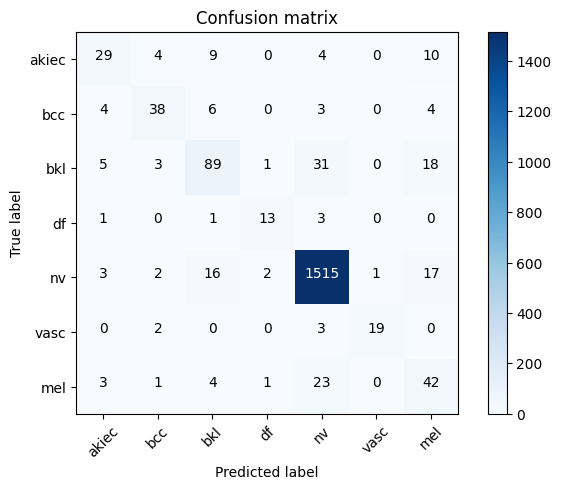

In [53]:
# Load saved state dict of trained model

state_dict = torch.load('densenet121_skin_lesion_class_bias_oversampling.pt')
model.load_state_dict(state_dict)


model.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(test_loader):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = model(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
plot_confusion_matrix(confusion_mtx, plot_labels)

### Class balance loss

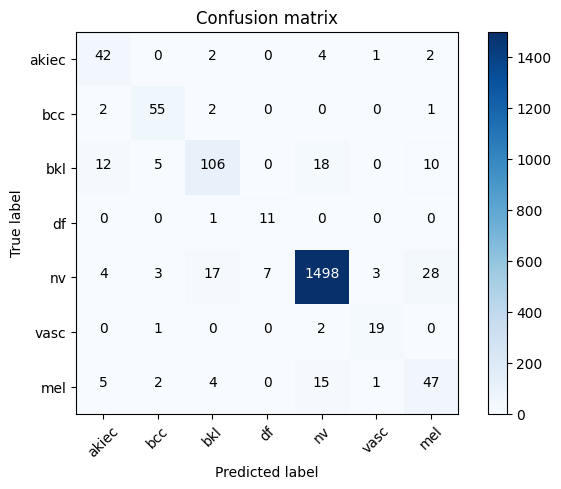

In [36]:



# Load saved state dict of trained model

state_dict = torch.load('densenet121_skin_lesion_class_bias_class_balance_loss.pt')
model.load_state_dict(state_dict)


model.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(test_loader):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = model(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
plot_confusion_matrix(confusion_mtx, plot_labels)

### Oversampling +  Class balance loss

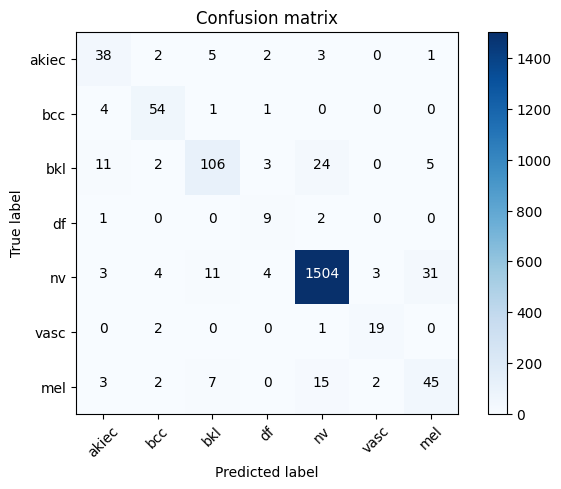

In [66]:





# Load saved state dict of trained model

state_dict = torch.load('densenet121_skin_lesion_class_bias_oversampling_class_balance_loss.pt')
model.load_state_dict(state_dict)


model.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(test_loader):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = model(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
plot_confusion_matrix(confusion_mtx, plot_labels)

### Oversampling + Weighted_cross-entropy loss

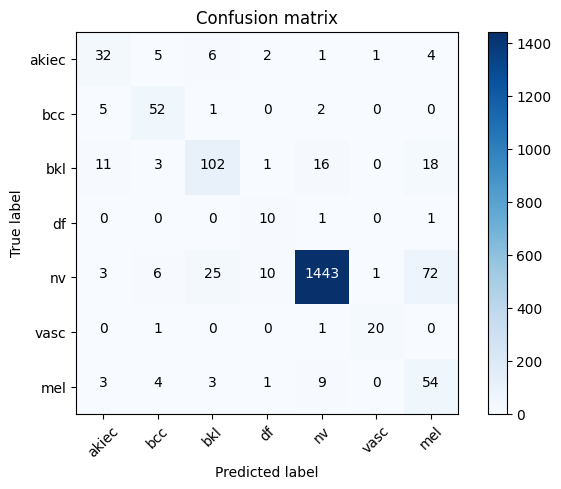

In [43]:



# Load saved state dict of trained model

state_dict = torch.load('densenet121_skin_lesion_weighted_cross-entropy_loss_oversampling.pt')
model.load_state_dict(state_dict)
densenet121_skin_lesion_class_bias_class_balance_loss.pt

model.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(test_loader):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = model(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
plot_confusion_matrix(confusion_mtx, plot_labels)

### Oversampling

In [54]:
# Generate a classification report
report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.64      0.52      0.57        56
         bcc       0.76      0.69      0.72        55
         bkl       0.71      0.61      0.65       147
          df       0.76      0.72      0.74        18
          nv       0.96      0.97      0.97      1556
        vasc       0.95      0.79      0.86        24
         mel       0.46      0.57      0.51        74

    accuracy                           0.90      1930
   macro avg       0.75      0.70      0.72      1930
weighted avg       0.90      0.90      0.90      1930



### Class balance loss

In [37]:
# Generate a classification report
report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.65      0.82      0.72        51
         bcc       0.83      0.92      0.87        60
         bkl       0.80      0.70      0.75       151
          df       0.61      0.92      0.73        12
          nv       0.97      0.96      0.97      1560
        vasc       0.79      0.86      0.83        22
         mel       0.53      0.64      0.58        74

    accuracy                           0.92      1930
   macro avg       0.74      0.83      0.78      1930
weighted avg       0.93      0.92      0.92      1930



### Oversampling + Class balance loss

In [67]:
# Generate a classification report
report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.63      0.75      0.68        51
         bcc       0.82      0.90      0.86        60
         bkl       0.82      0.70      0.75       151
          df       0.47      0.75      0.58        12
          nv       0.97      0.96      0.97      1560
        vasc       0.79      0.86      0.83        22
         mel       0.55      0.61      0.58        74

    accuracy                           0.92      1930
   macro avg       0.72      0.79      0.75      1930
weighted avg       0.92      0.92      0.92      1930



### Oversampling + Weighted_cross-entropy loss

In [44]:
# Generate a classification report
report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.59      0.63      0.61        51
         bcc       0.73      0.87      0.79        60
         bkl       0.74      0.68      0.71       151
          df       0.42      0.83      0.56        12
          nv       0.98      0.93      0.95      1560
        vasc       0.91      0.91      0.91        22
         mel       0.36      0.73      0.48        74

    accuracy                           0.89      1930
   macro avg       0.68      0.80      0.72      1930
weighted avg       0.92      0.89      0.90      1930



## Bias Investigation

### 1. Class

### Oversampling

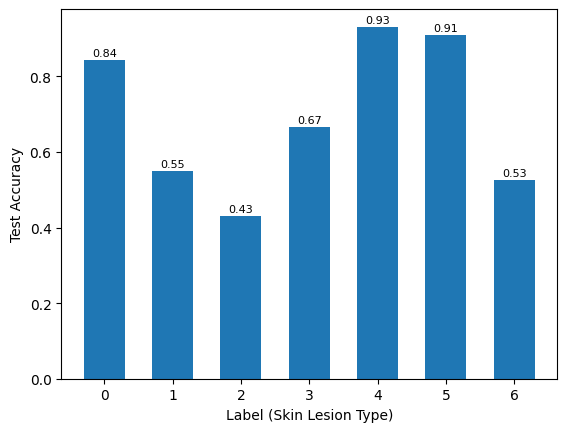

In [85]:
label_accuracy = np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7), label_accuracy, width=0.6)
plt.xlabel('Label (Skin Lesion Type)')
plt.ylabel('Test Accuracy')

# Add values above the bars
for i, v in enumerate(label_accuracy):
    plt.text(i, v+0.01, str(round(v,2)), ha='center', fontsize=8)

plt.show()


### Class balance loss

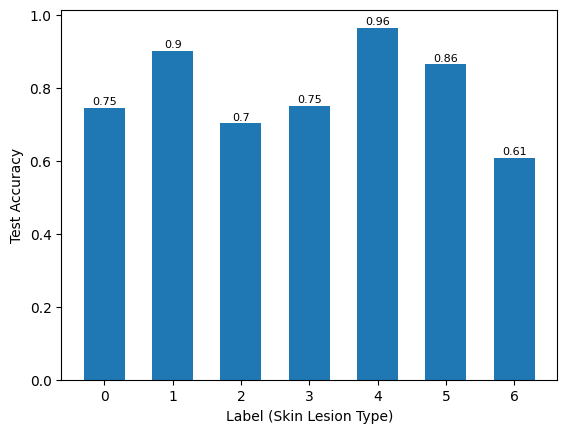

In [68]:
label_accuracy = np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7), label_accuracy, width=0.6)
plt.xlabel('Label (Skin Lesion Type)')
plt.ylabel('Test Accuracy')

# Add values above the bars
for i, v in enumerate(label_accuracy):
    plt.text(i, v+0.01, str(round(v,2)), ha='center', fontsize=8)

plt.show()


### Over sampling + Class balance loss

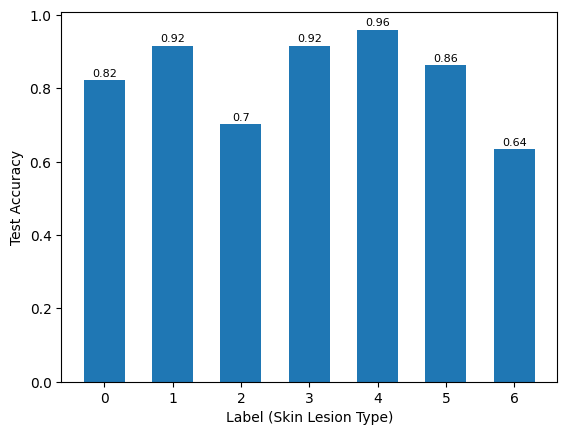

In [38]:
label_accuracy = np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7), label_accuracy, width=0.6)
plt.xlabel('Label (Skin Lesion Type)')
plt.ylabel('Test Accuracy')

# Add values above the bars
for i, v in enumerate(label_accuracy):
    plt.text(i, v+0.01, str(round(v,2)), ha='center', fontsize=8)

plt.show()


### Oversampling + Weighted_cross-entropy loss

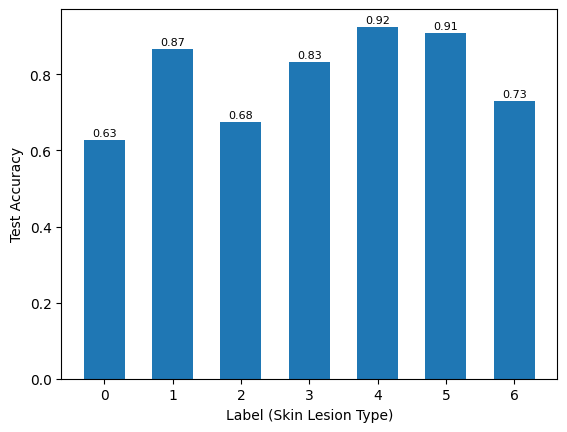

In [45]:
label_accuracy = np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7), label_accuracy, width=0.6)
plt.xlabel('Label (Skin Lesion Type)')
plt.ylabel('Test Accuracy')

# Add values above the bars
for i, v in enumerate(label_accuracy):
    plt.text(i, v+0.01, str(round(v,2)), ha='center', fontsize=8)

plt.show()
